main_dev_pmgus.ipynb
# Pre-Market Momentum "Gap-up" Screener & Strategy (#1-DT, #2-Swing)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pytz  # timezone
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm  # Visualize loop progress
from sklearn.linear_model import LinearRegression
from tenacity import retry, stop_after_attempt, wait_fixed

pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [12]:
import os
import requests
from datetime import datetime, timedelta
from dotenv import load_dotenv

# LEVEL #0
| INITIAL DATA IMPORT |
|-|
| LEVEL #0 |

In [13]:
# base file path and file path setup
base_dir_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/' 
std_file_name_str = 'tv_screen_gap-up_'

#####---------------------#####
# screen_date = '2024-11-15' #----> $RSI
# screen_date = '2024-11-20' #----> $RSI, $ADMA
# screen_date = '2024-11-21' #----> $MARA
screen_date = '2024-11-22' # $ESTC

#####---------------------#####

file_type = '.csv'
filename = base_dir_path + std_file_name_str + screen_date + file_type

# read the csv file
print(filename)
trading_view_df = pd.read_csv(filename)
print(len(trading_view_df))
# print first 5 ticker Symbols only
print(trading_view_df['Symbol'].head(5))

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/tv_screen_gap-up_2024-11-22.csv
767
0     AAPL
1     TSLA
2    BRK.B
3      TSM
4      WMT
Name: Symbol, dtype: object


# LEVEL #1
| PRIMARY SCREENING |
|-|
| LEVEL #1 |

In [14]:
# CREATE CATEGORIES FOR MARKET CAP
def categorize_market_cap(df):
    """Categorize stocks based on market capitalization."""
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    conditions = [
        (df['Market capitalization'] >= 200_000_000_000),  # Titans
        (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
        (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
        (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
        (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
        (df['Market capitalization'] <= 50_000_000)  # Shrimp
    ]
    categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    return df

# execute categorization
category_setup_df = categorize_market_cap(trading_view_df).copy()

# drop Undefined marketCapType
category_setup_df = category_setup_df[category_setup_df['marketCapType'] != 'Undefined']

# convert necessary columns to numeric
def convert_columns_to_numeric(df, columns):
    """Convert specified columns to numeric types."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# list of columns to convert
numeric_columns = [
    'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
    'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
    'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
    'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
]

# Apply conversion
category_setup_df = convert_columns_to_numeric(category_setup_df, numeric_columns)

# CRITERIA CONFIGURATION FOR EACH MARKET CAP CATEGORY
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.03,
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    # "Midlers" in TradingView
    "Midlers": { 
        "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

# FILTER STOCKS BASED ON CONFIGURATION CRITERIA - STAGING
def filter_stocks(df, config):
    """Filter stocks based on configuration criteria."""
    conditions = (
        (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
        (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
        (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
        (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
        (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
        (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
        (df['Volatility 1 day'] >= df['Volatility 1 week']) &
        (df['Volatility 1 day'] >= df['Volatility 1 month']) &
        (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
    )
    return df[conditions]

# SCREEN STOCKS BY CATEGORY
def screen_stocks_by_category(df, category):
    """Filter stocks in a category using predefined criteria."""
    config = criteria_config.get(category, {})
    filtered_df = filter_stocks(df, config)
    return filtered_df

# EXECUTE KEY SCREENING FUNCTION AND CREATE DATAFRAME
smash_df = pd.DataFrame()
categories = category_setup_df['marketCapType'].unique()

for category in categories:
    category_df = category_setup_df[category_setup_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    smash_df = pd.concat([smash_df, gap_up_stage_df], ignore_index=True)

# rendered column list and ordering
cols_list = [
    'Symbol', 
    'Description', 
    'marketCapType', 
    'Pre-market Change %', 
    'Pre-market Gap %', 
    'marketCapType',
    'Market capitalization',
    'Price', 
    'Pre-market Open', 
    'Industry', 
    'Index', 
    'Sector', 
    'Exchange',
    'Recent earnings date', 
    'Upcoming earnings date', 
    'Float shares outstanding', 
    'Average Volume 10 days',
    'Average Volume 30 days', 
    'Average Volume 90 days',
    'Relative Volume 1 day', 
    'Relative Volume 5 minutes', 
    'Relative Volume 30 minutes', 
    'Relative Volume at Time', 
    'Analyst Rating',
    'Technical Rating 5 minutes'
]

# filter columns to only include those present in the DataFrame
existing_cols = [col for col in cols_list if col in smash_df.columns]
smash_df = smash_df[existing_cols]

# sort and reset index
smash_df = smash_df.sort_values(
    by=['Pre-market Change %', 'Price'],
    ascending=[False, False]).reset_index(drop=True)


print(f"{smash_df.shape[0]} stockes found in the screener.")

51 stockes found in the screener.


In [85]:
# # display(smash_df.head(4))
# print(len(smash_df))
# print(smash_df)

| TECHNICAL ANALYSIS |
|-|
| LEVEL #2 |

RVOL retriever ????

# Share and / or some of these to setup KEY LEVELS

In [15]:
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

In [16]:
print(screen_date)

2024-11-22


fix all this shit. yahoo will give you close. 
you get pre-market from tradingview (0615?)

In [17]:
def technical_screen(df, test_date, lookback_period=100):
    """
    Calculate technical indicators using TA library and apply filters for a specific date.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing stock symbols
    test_date (str): Date to test in 'YYYY-MM-DD' format
    lookback_period (int): Number of days to look back for calculating indicators
    
    Returns:
    pd.DataFrame: DataFrame with technical indicators and filtered results
    """
    # Calculate start date for historical data
    start_date = (datetime.strptime(test_date, '%Y-%m-%d') - 
                 timedelta(days=lookback_period)).strftime('%Y-%m-%d')
    end_date = (datetime.strptime(test_date, '%Y-%m-%d') + 
                timedelta(days=1)).strftime('%Y-%m-%d')
    
    symbols = df['Symbol'].tolist()
    technical_data = []
    
    for symbol in symbols:
        try:
            # Get historical data
            ticker = yf.Ticker(symbol)
            hist = ticker.history(start=start_date, end=end_date, interval='1d')
            
            if not hist.empty:
                # Calculate indicators using TA library
                close_prices = hist['Close']
                
                # RSI
                rsi = RSIIndicator(close=close_prices, window=14)
                hist['RSI'] = rsi.rsi()
                
                # Moving Averages
                sma5 = SMAIndicator(close=close_prices, window=5)
                sma20 = SMAIndicator(close=close_prices, window=20)
                sma50 = SMAIndicator(close=close_prices, window=50)
                # sma100 = SMAIndicator(close=close_prices, window=100)
                # sma200 = SMAIndicator(close=close_prices, window=200)
                # macd = MACD(close=close_prices)

                hist['MA5'] = sma5.sma_indicator()
                hist['MA20'] = sma20.sma_indicator()
                hist['MA50'] = sma50.sma_indicator()
                # hist['MA100'] = sma100.sma_indicator()
                # hist['MA200'] = sma200.sma_indicator()
                # hist['MACD'] = macd.macd()
                
                # Get most recent values
                current_price = hist['Close'].iloc[-1]
                current_rsi = hist['RSI'].iloc[-1]
                current_ma5 = hist['MA5'].iloc[-1]
                current_ma20 = hist['MA20'].iloc[-1]
                current_ma50 = hist['MA50'].iloc[-1]
                # current_ma100 = hist['MA100'].iloc[-1]
                # current_ma200 = hist['MA200'].iloc[-1]
                # current_macd = hist['MACD'].iloc[-1]
                
                technical_data.append({
                    'Symbol': symbol,
                    'yahooPrice': current_price,
                    'RSI': current_rsi,
                    'MA5': current_ma5,
                    'MA20': current_ma20,
                    'MA50': current_ma50,
                    # 'MA100': current_ma100,
                    # 'MA200': current_ma200,
                    # 'MACD': current_macd,
                    'Volume': hist['Volume'].iloc[-1],
                    # add curret volume ???? data source ????
                    # 'RVOL8': hist['Volume'].iloc[-1] / hist['Volume'].rolling(8).mean().iloc[-1],
                    'Date': hist.index[-1]
                })
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    result_df = pd.DataFrame(technical_data)
    return result_df


In [18]:
explode_df = technical_screen(smash_df, screen_date)

explode_df

,Symbol,yahooPrice,RSI,MA5,MA20,MA50,Volume,Date
0,ESTC,108.029999,83.685178,93.013998,86.668000,81.775400,7726800,2024-11-22 00:00:00-05:00
1,GAP,24.870001,69.978612,21.978001,21.731000,21.340442,35392100,2024-11-22 00:00:00-05:00
2,PTON,9.540000,71.477090,8.496000,7.951500,6.206600,20323300,2024-11-22 00:00:00-05:00
3,ANF,151.990005,59.961949,143.274002,139.974000,142.734000,2637400,2024-11-22 00:00:00-05:00
4,NUVL,94.930000,54.274615,91.516000,91.347999,97.803100,419600,2024-11-22 00:00:00-05:00
5,KTOS,26.629999,60.567643,25.503999,24.855000,24.444600,839900,2024-11-22 00:00:00-05:00
6,SOUN,8.250000,69.004760,6.874000,6.350500,5.509400,107545100,2024-11-22 00:00:00-05:00
7,TGTX,35.070000,69.770150,32.140000,28.944250,25.613200,2576300,2024-11-22 00:00:00-05:00
8,WTS,215.169998,62.272787,210.279999,205.181000,204.696800,160600,2024-11-22 00:00:00-05:00
9,NVMI,179.759995,42.865149,177.566000,188.255499,194.562800,133000,2024-11-22 00:00:00-05:00


In [90]:
# [print(smash_df.columns)]

In [19]:
# merge join the two dataframes
explode_df = pd.merge(smash_df[['Symbol', 
                                'Description', 
                                'Exchange',
                                'Index',
                                'Sector',
                                'Float shares outstanding',
                                'marketCapType', 
                                'Pre-market Change %', 
                                'Pre-market Gap %', 
                                'Market capitalization', 
                                'Price', 'Pre-market Open', 
                                'Relative Volume 5 minutes', 
                                'Industry',
                                'Analyst Rating',
                                'Technical Rating 5 minutes']], explode_df, on='Symbol', how='inner')


print(len(explode_df))
print(len(explode_df.columns))
display(explode_df.head(2))
# print(explode_df)

51
24


,Symbol,Description,Exchange,Index,Sector,Float shares outstanding,marketCapType,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Relative Volume 5 minutes,Industry,Analyst Rating,Technical Rating 5 minutes,yahooPrice,RSI,MA5,MA20,MA50,Volume,Date
0,ESTC,Elastic N.V.,NYSE,"ISE CTA Cloud Computing, Nasdaq US Mid Cap Growth, Russell 3000, Russell 1000",Technology services,8.558762e+07,Mid caps,Mid caps,28.566876,25.464783,9.671434e+09,94.13,118.10,5.467386,Packaged software,Buy,Buy,108.029999,83.685178,93.013998,86.668,81.775400,7726800,2024-11-22 00:00:00-05:00
1,GAP,"Gap, Inc. (The)",NYSE,"S&P MidCap 400, Russell 3000, Russell 1000",Retail trade,2.261022e+08,Mid caps,Mid caps,15.335753,15.925590,8.294025e+09,22.04,25.55,4.578218,Apparel/Footwear retail,Buy,Buy,24.870001,69.978612,21.978001,21.731,21.340442,35392100,2024-11-22 00:00:00-05:00


operations-START

# LEVEL [-1] or [-2] (END (or near the END))
| FINAL MOMENTUM SCREENER (& filter conditions) |
|-|
| LEVEL #[-1] or 2nd to last |

In [20]:
def final_momentum_filter(df):
    """
    Final filter for high-probability morning momentum trades
    """
    return df[
        # Strong pre-market movement but not overextended
        (
            (df['Pre-market Change %'] > 3.0) |
            ((df['Pre-market Change %'] > 1.5) & (df['Relative Volume 5 minutes'] > 5.0))
        ) &
        
        # Volume validation
        (df['Relative Volume 5 minutes'] > 2.0) &
        
        # Industry/sector grouping
        (df.groupby('Industry')['Pre-market Change %'].transform('count') > 1)
            ].sort_values('Pre-market Change %', ascending=False)
    # ].sort_values('Pre-market Change %', ascending=False).head(3)

In [26]:
pmgus_sl_df = final_momentum_filter(explode_df)

In [28]:
# print(len(pmgus_sl_df))
# print(pmgus_sl_df)
display(pmgus_sl_df)

,Symbol,Description,Exchange,Index,Sector,Float shares outstanding,marketCapType,marketCapType,Pre-market Change %,Pre-market Gap %,Market capitalization,Price,Pre-market Open,Relative Volume 5 minutes,Industry,Analyst Rating,Technical Rating 5 minutes,yahooPrice,RSI,MA5,MA20,MA50,Volume,Date
0,ESTC,Elastic N.V.,NYSE,"ISE CTA Cloud Computing, Nasdaq US Mid Cap Growth, Russell 3000, Russell 1000",Technology services,8.558762e+07,Mid caps,Mid caps,28.566876,25.464783,9.671434e+09,94.13,118.10,5.467386,Packaged software,Buy,Buy,108.029999,83.685178,93.013998,86.668000,81.775400,7726800,2024-11-22 00:00:00-05:00
1,GAP,"Gap, Inc. (The)",NYSE,"S&P MidCap 400, Russell 3000, Russell 1000",Retail trade,2.261022e+08,Mid caps,Mid caps,15.335753,15.925590,8.294025e+09,22.04,25.55,4.578218,Apparel/Footwear retail,Buy,Buy,24.870001,69.978612,21.978001,21.731000,21.340442,35392100,2024-11-22 00:00:00-05:00
2,PTON,"Peloton Interactive, Inc.",NASDAQ,"NASDAQ Composite, Russell 2000, Russell 3000, NASDAQ Industrials, Mini-Russell 2000",Consumer services,3.403142e+08,Mid caps,Mid caps,5.408389,6.401766,3.456021e+09,9.06,9.64,2.460071,Other consumer services,Neutral,Neutral,9.540000,71.477090,8.496000,7.951500,6.206600,20323300,2024-11-22 00:00:00-05:00
3,ANF,Abercrombie & Fitch Company,NYSE,"Russell 2000, S&P MidCap 400, Nasdaq US Mid Cap Growth, Russell 3000, Mini-Russell 2000",Retail trade,5.011582e+07,Mid caps,Mid caps,2.500530,1.716465,7.231206e+09,141.57,144.00,8.358369,Apparel/Footwear retail,Buy,Neutral,151.990005,59.961949,143.274002,139.974000,142.734000,2637400,2024-11-22 00:00:00-05:00
4,NUVL,"Nuvalent, Inc.",NASDAQ,"NASDAQ Composite, Russell 2000, Nasdaq US Small Cap Growth, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",Health technology,4.145189e+07,Mid caps,Mid caps,2.447967,2.447967,6.588704e+09,92.73,95.00,5.149481,Biotechnology,Strong buy,Sell,94.930000,54.274615,91.516000,91.347999,97.803100,419600,2024-11-22 00:00:00-05:00
5,KTOS,"Kratos Defense & Security Solutions, Inc.",NASDAQ,"NASDAQ Composite, Russell 2000, Russell 3000, NASDAQ Industrials, Mini-Russell 2000",Electronic technology,1.477158e+08,Mid caps,Mid caps,2.324695,2.400915,3.964179e+09,26.24,26.87,5.079314,Aerospace & defense,Buy,Buy,26.629999,60.567643,25.503999,24.855000,24.444600,839900,2024-11-22 00:00:00-05:00
12,ASAN,"Asana, Inc.",NYSE,"Russell 2000, ISE CTA Cloud Computing, Nasdaq US Small Cap Growth, Russell 3000, Mini-Russell 2000",Technology services,8.234946e+07,Mid caps,Mid caps,1.698370,1.562500,3.358619e+09,14.72,14.95,10.539100,Packaged software,Neutral,Sell,15.740000,75.841205,14.396000,13.604000,12.554200,3399800,2024-11-22 00:00:00-05:00


In [29]:
# export to csv
short_list_fp_fn = f'/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/pmgus_short_list_dataframe_output_{screen_date}.csv'
pmgus_sl_df.to_csv(short_list_fp_fn, index=False)

# NEWS

NEWS resources (alt) Re:IT news data source;
NewsAPI.org Documentation: https://newsapi.org/docs
GNews API Documentation: https://gnews.io/docs/v4
Natural Language Toolkit (NLTK): https://www.nltk.org/ (supports multiple languages)
spaCy (NLP Library): https://spacy.io/usage/models (has models for Italian)



In [30]:
print(len(pmgus_sl_df))
print(pmgus_sl_df.columns)

7
Index(['Symbol', 'Description', 'Exchange', 'Index', 'Sector',
       'Float shares outstanding', 'marketCapType', 'marketCapType',
       'Pre-market Change %', 'Pre-market Gap %', 'Market capitalization',
       'Price', 'Pre-market Open', 'Relative Volume 5 minutes', 'Industry',
       'Analyst Rating', 'Technical Rating 5 minutes', 'yahooPrice', 'RSI',
       'MA5', 'MA20', 'MA50', 'Volume', 'Date'],
      dtype='object')


## NEWS - yahoo finance

In [31]:
# Retrieve the first Symbol from the pmgus_sl_df DataFrame
the_stock_str = pmgus_sl_df['Symbol'].iloc[0]
# verify string dtype
the_stock_str = str(the_stock_str)

# print the first Symbol as str
print(the_stock_str)

ESTC


In [32]:
# get yahoo finance NEWS data
def get_stock_news_df(ticker_symbol, hours_lookback=24):
    """
    Creates a DataFrame of news articles for a given ticker
    
    Parameters:
    -----------
    ticker_symbol : str
        The stock symbol to get news for
    hours_lookback : int
        Number of hours to look back for news
        
    Returns:
    --------
    pandas.DataFrame with columns:
        - Symbol
        - Headline
        - Publisher
        - Time
        - Link
    """
    # Get the ticker object
    stock = yf.Ticker(ticker_symbol)
    
    # Get all news
    news_data = stock.get_news()
    
    # Create lists to store our data
    articles = []
    
    # Process each news article
    for article in news_data:
        articles.append({
            'Symbol': ticker_symbol,
            'Headline': article['title'],
            'Publisher': article['publisher'],
            'Time': datetime.fromtimestamp(article['providerPublishTime']).strftime('%Y-%m-%d %H:%M:%S'),
            'Link': article['link']
        })
    
    # Create DataFrame
    yf_news_df = pd.DataFrame(articles)
    
    # Sort by time, most recent first
    yf_news_df = yf_news_df.sort_values('Time', ascending=False)
    
    return yf_news_df


# EXECUTE
yf_news_df = get_stock_news_df(the_stock_str)
display(yf_news_df.head(5))

,Symbol,Headline,Publisher,Time,Link
0,ESTC,Watch These Elastic Stock Price Levels After Post-Earnings Surge,Investopedia,2024-11-22 09:30:23,https://finance.yahoo.com/m/6e79844a-bb3f-3277-8001-e73878f504c7/watch-these-elastic-stock.html
1,ESTC,Why Elastic stock is up today,StockStory,2024-11-22 08:55:12,https://finance.yahoo.com/news/why-elastic-estc-stock-today-165512582.html
2,ESTC,Why Elastic Stock Flew Higher Today,Motley Fool,2024-11-22 08:23:40,https://finance.yahoo.com/m/5c9a8b47-b816-3062-9e4a-8418acc50afc/why-elastic-stock-flew-higher.html
3,ESTC,"UBS Raises Price Target on Elastic NV to $140 From $95, Maintains Buy Rating",MT Newswires,2024-11-22 08:03:40,https://finance.yahoo.com/news/ubs-raises-price-target-elastic-160340575.html
4,ESTC,Elastic Stock Surges As AI Data Demand Fuels 'Bounce Back' Quarter,Investor's Business Daily,2024-11-22 07:55:41,https://finance.yahoo.com/m/6e7abda3-bab6-3b76-8ca6-9d0be8aa2945/elastic-stock-surges-as-ai.html


more news add to the existing df
-wsj api?
-nyt api
-tradingview?
-marketwatch veteran discount and sign up
-real time streaming?
-markov chains, stochastic vars
-auto regression, + ar vectors
-stocktwits?

### NEWS - NewsAPI

IMPORTANT! - note the the free version has 24hr delay on news 

In [33]:
class NewsAPIClient:
    def __init__(self):
        load_dotenv()
        self.api_key = os.getenv('NewsAPI_KEY')
        self.base_url = 'https://newsapi.org/v2'
        self.headers = {'X-Api-Key': self.api_key}
    
    def search_company_news(self, company, days_back=7, language='en', sort_by='publishedAt'):
        """
        Search for company-related news articles
        
        Args:
            company (str): Company name or ticker
            days_back (int): Number of days to look back
            language (str): Article language (e.g., 'en' for English)
            sort_by (str): Sort method ('relevancy', 'popularity', 'publishedAt')
        """
        from_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
        
        params = {
            'q': company,
            'from': from_date,
            'language': language,
            'sortBy': sort_by,
        }
        
        response = requests.get(
            f'{self.base_url}/everything',
            headers=self.headers,
            params=params
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            raise Exception(f"API request failed with status {response.status_code}: {response.text}")

# EXECUTE news api data retrieval
try:
    news_client = NewsAPIClient()
    
    # Verify API key is loaded
    if not news_client.api_key:
        raise ValueError("API key not found in .env file. Please check your NewsAPI_KEY variable.")
    
    # # Define the stock string before using it
    # the_stock_str = "TSLA"  # or whatever stock you want to search for
    
    # Test with a sample request
    the_stock_news = news_client.search_company_news(company=the_stock_str, days_back=1)
    
    print(f"Total articles found: {len(the_stock_news['articles'])}")
    # Print article to output
    if the_stock_news.get('articles'):
        # all articles available
        for article in the_stock_news['articles'][:10]:
            # print the length or number of articles returned
            print("\nArticle Details:")
            print(f"Title: {article['title']}")
            print(f"Source: {article['source']['name']}")
            # Fix the datetime parsing - publishedAt comes as ISO format string
            published_date = datetime.fromisoformat(article['publishedAt'].replace('Z', '+00:00'))
            print(f"Published At: {published_date.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Link: {article['url']}")

    else:
        print("No articles found in the response")

except Exception as e:
    print(f"Error: {str(e)}")

Total articles found: 2

Article Details:
Title: Elastic Stock Rockets Higher As Data Software Player Posts Big Earnings Beat
Source: Investor's Business Daily
Published At: 2024-11-21 21:18:41
Link: https://www.investors.com/news/technology/elastic-stock-october-earnings-results-estc-stock-news/

Article Details:
Title: KBC Group NV Reduces Stock Position in Elastic (NYSE:ESTC)
Source: ETF Daily News
Published At: 2024-11-21 09:19:00
Link: https://www.etfdailynews.com/2024/11/21/kbc-group-nv-reduces-stock-position-in-elastic-nyseestc/


NEWS - Italian NEWS

NEWS - ????

LEVELS

In [101]:
""" 
NOTES: What key levels should i use? start with a lot, then refine later maybe
try to sort by importance, or weight, or confluence.
  
list of key levels brainstorm. try to order this by weight (confluence);
- pre-market high
- pre-market low
- pre-market open
- yesterday's high
- yesterday's low
- yesterday's close
- yesterday's open
- 52 week high
- 52 week low
- MA50
- MA200
- MA20
- MA5
- VWAP
- fibonacci retracement levels

OTHER;
pivot points
RSI
MACD
POC
actual price
pre-market close

"""

" \nNOTES: What key levels should i use? start with a lot, then refine later maybe\ntry to sort by importance, or weight, or confluence.\n  \nlist of key levels brainstorm. try to order this by weight (confluence);\n- pre-market high\n- pre-market low\n- pre-market open\n- yesterday's high\n- yesterday's low\n- yesterday's close\n- yesterday's open\n- 52 week high\n- 52 week low\n- MA50\n- MA200\n- MA20\n- MA5\n- VWAP\n- fibonacci retracement levels\n\nOTHER;\npivot points\nRSI\nMACD\nPOC\nactual price\npre-market close\n\n"

In [102]:
# determine KEY LEVELS










operations-END

# DATA ENRICHMENT
| ENRICH DATA with other data sources |
|-|
| Enrich and augment the dataframe |

# Perfomance Testing
| Perfomance Testing (after market close for DAY)|
|-|
| test the performance of the earlier selected target PMGU stock |

In [103]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pytz

In [104]:
def plot_daily_price(symbol, date_str):
    """
    Plot stock price action for a single trading day with EST time
    """
    # Get data
    start_date = pd.to_datetime(date_str)
    end_date = start_date + timedelta(days=1)
    
    # Download 1-minute data
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date, interval='1m')
    
    # Convert index to Eastern Time
    df.index = df.index.tz_convert('US/Eastern')
    
    # Filter for market hours (9:30 AM - 4:00 PM ET)
    market_open = pd.Timestamp(date_str + ' 09:30:00', tz='US/Eastern')
    market_close = pd.Timestamp(date_str + ' 16:00:00', tz='US/Eastern')
    df = df.between_time('9:30', '16:00')
    
    # Create plot with dark theme
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot price
    ax.plot(df.index, df['Close'], color='white', linewidth=1)
    
    # # Add VWAP
    # df['Cumulative_PV'] = (df['Close'] * df['Volume']).cumsum()
    # df['Cumulative_Volume'] = df['Volume'].cumsum()
    # df['VWAP'] = df['Cumulative_PV'] / df['Cumulative_Volume']
    # ax.plot(df.index, df['VWAP'], color='purple', alpha=0.7, linestyle='--', label='VWAP')
    
    # Format x-axis for EST time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # set every 5 mins ticks for plot
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
    plt.xticks(rotation=45)
    
    # Add title and labels
    plt.title(f'${symbol} Price Action on {date_str}', color='white', pad=20)
    plt.ylabel('Price ($)', color='white')
    
    # Add grid
    ax.grid(True, alpha=0.2)
    
    # Add entry price reference line
    entry_price = 22.63
    ax.axhline(y=entry_price, color='yellow', linestyle='--', alpha=0.5, label='Entry Price')
    
    # Add legend
    plt.legend()
    
    # Adjust layout and margins
    plt.tight_layout()
    
    plt.show()


#### EXECUTE for TARGET ticker symbol (1) ####
plot_daily_price(target_ticker_str, screen_date)

NameError: name 'target_ticker_str' is not defined

In [ ]:
# addding KEY LEVELS
# EPs, SLs, RLs, TPs
# pre-market high, low, open, close
# yesterday, high, low, open, close
# fib levels
# auto regression
# vector auto regression
# MAs
# VWAP
# Volume
# RSI
# MACD

In [ ]:
def plot_recent_price_levels(symbol, target_date):
    """
    Plot recent price action with key levels for pre-market analysis
    Using 15-min candles for smoother visualization and key trading levels
    """
    # Calculate start date (10 trading days before target date)
    end_date = pd.to_datetime(target_date)
    start_date = end_date - pd.DateOffset(days=14)  # Add extra days for weekends
    
    # Download data at 15-minute intervals for smoother chart
    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date, interval='15m')
    
    if df.empty:
        print(f"No data available for {symbol}")
        return
    
    # Ensure timezone handling
    if df.index.tz is not None:
        df.index = df.index.tz_convert('US/Eastern')
    else:
        df.index = df.index.tz_localize('US/Eastern')
    
    # Filter for market hours only
    df = df.between_time('9:30', '16:00')
    
    # Keep only last 10 trading days
    unique_days = pd.Series(df.index.date).unique()
    if len(unique_days) > 10:
        last_10_days = unique_days[-10:]
        df = df[df.index.date.isin(last_10_days)]
    
    # Calculate key levels
    daily_highs = df.groupby(df.index.date)['High'].max()
    daily_lows = df.groupby(df.index.date)['Low'].min()
    
    # Calculate daily VWAP
    df['Cumulative_PV'] = df.groupby(df.index.date).apply(
        lambda x: (x['Close'] * x['Volume']).cumsum()
    )
    df['Cumulative_Volume'] = df.groupby(df.index.date).apply(
        lambda x: x['Volume'].cumsum()
    )
    df['VWAP'] = df['Cumulative_PV'] / df['Cumulative_Volume']
    
    # Create plot with dark theme
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[3, 1], gridspec_kw={'hspace': 0.3})
    
    # Plot 1: Price action using a smoother line
    ax1.plot(df.index, df['Close'].rolling(window=4).mean(), 
             color='white', linewidth=1.5, label='Price (Smoothed)')
    
    # Add daily VWAP
    ax1.plot(df.index, df['VWAP'], 
             color='purple', linestyle='--', alpha=0.7, label='VWAP')
    
    # Add key levels from most recent full trading day
    if len(daily_highs) > 1:
        prev_day_high = daily_highs.iloc[-2]
        prev_day_low = daily_lows.iloc[-2]
        prev_day_close = df[df.index.date == unique_days[-2]]['Close'].iloc[-1]
        
        # Previous day's levels
        ax1.axhline(y=prev_day_high, color='red', linestyle=':', alpha=0.5, label='Prev High')
        ax1.axhline(y=prev_day_low, color='green', linestyle=':', alpha=0.5, label='Prev Low')
        ax1.axhline(y=prev_day_close, color='yellow', linestyle=':', alpha=0.5, label='Prev Close')
        
        # Add labels
        for level, color, label in [
            (prev_day_high, 'red', f'PDH: ${prev_day_high:.2f}'),
            (prev_day_low, 'green', f'PDL: ${prev_day_low:.2f}'),
            (prev_day_close, 'yellow', f'PDC: ${prev_day_close:.2f}')
        ]:
            ax1.annotate(label, 
                        xy=(df.index[-1], level),
                        xytext=(10, 0),
                        textcoords='offset points',
                        color=color,
                        alpha=0.7)
    
    # Calculate and plot key swing levels
    swing_high = df['High'].rolling(window=10).max().iloc[-1]
    swing_low = df['Low'].rolling(window=10).min().iloc[-1]
    
    ax1.axhline(y=swing_high, color='red', linestyle='-', alpha=0.3, label='Swing High')
    ax1.axhline(y=swing_low, color='green', linestyle='-', alpha=0.3, label='Swing Low')
    
    # Volume plot with moving average
    volume_ma = df['Volume'].rolling(window=5).mean()
    ax2.bar(df.index, df['Volume'], color='blue', alpha=0.3, label='Volume')
    ax2.plot(df.index, volume_ma, color='white', alpha=0.7, label='Volume MA')
    
    # Format axes
    ax1.set_title(f'${symbol} Recent Price Action (15min)', pad=20)
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.2)
    ax1.legend(loc='upper left')
    
    ax2.set_title('Volume Analysis', pad=20)
    ax2.set_ylabel('Volume')
    ax2.grid(True, alpha=0.2)
    
    # Format dates on x-axis
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'prev_day_high': prev_day_high if len(daily_highs) > 1 else None,
        'prev_day_low': prev_day_low if len(daily_highs) > 1 else None,
        'prev_day_close': prev_day_close if len(daily_highs) > 1 else None,
        'swing_high': swing_high,
        'swing_low': swing_low,
        'last_close': df['Close'].iloc[-1],
        'last_vwap': df['VWAP'].iloc[-1]
    }

In [ ]:
print(screen_date)

2024-11-21


/var/folders/8w/4mj_4m4d0rs1q22bl9g77hhw0000gn/T/ipykernel_69268/350119909.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


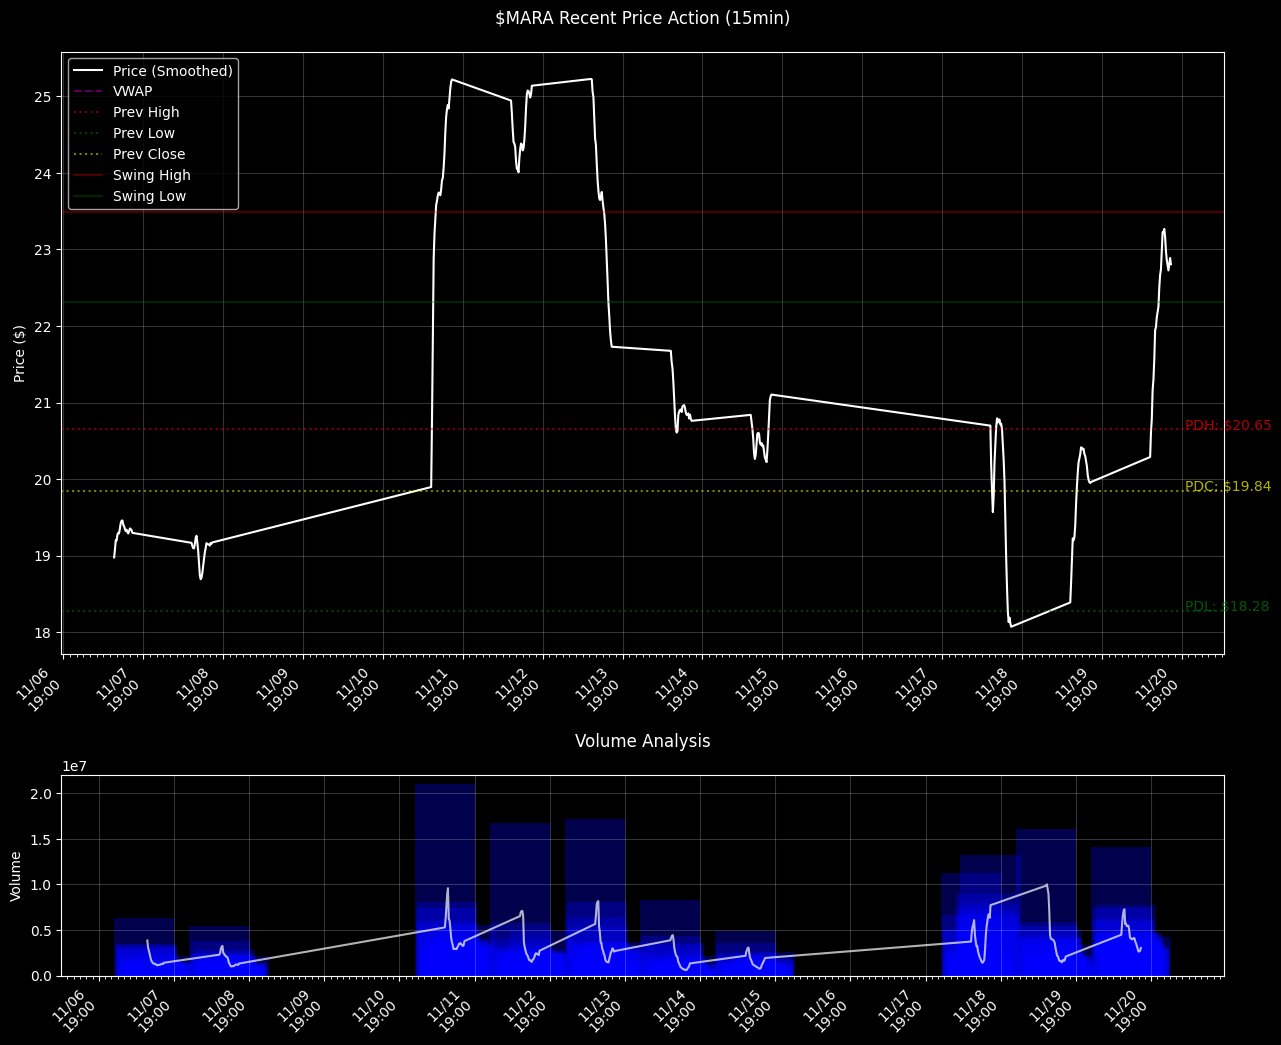

Previous Day High: $20.65
Previous Day Low: $18.28
10-Day High: $23.49
10-Day Low: $22.31
Last Close: $22.61
Last VWAP: $nan


In [ ]:
levels = plot_recent_price_levels(target_ticker_str, screen_date)
print(f"Previous Day High: ${levels['prev_day_high']:.2f}")
print(f"Previous Day Low: ${levels['prev_day_low']:.2f}")
print(f"10-Day High: ${levels['swing_high']:.2f}")
print(f"10-Day Low: ${levels['swing_low']:.2f}")
print(f"Last Close: ${levels['last_close']:.2f}")
print(f"Last VWAP: ${levels['last_vwap']:.2f}")

# In Progress Below

In [ ]:
#### Export data from fidelity
### LOAD fidelity trade history data
## clean data for PMGUS trades only to df
# plot trade BUYs/SELLs from df on existing chart
# think about embedded data like the EP, SPs, etc. on/in the chart
# like informational or part of informational one pager

#import fidelity trade history data 
fidelity_fp_fn = f'/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/fidelity_Accounts_History_{screen_date}.csv'
fidelity_df = pd.read_csv(fidelity_fp_fn)

display(fidelity_df.head(1))
# display(fidelity_df)

,Run Date,Account,Action,Symbol,Description,Type,Quantity,Price ($),Commission ($),Fees ($),Accrued Interest ($),Amount ($),Settlement Date
0,11/21/2024,Individual X69853518,YOU SOLD SOFI TECHNOLOGIES INC COM (SOFI) (Margin),SOFI,SOFI TECHNOLOGIES INC COM,Margin,-650.0,14.88,NaN,0.27,NaN,9671.73,11/22/2024


In [ ]:
# ensure proper data types
fidelity_df['Symbol'] = fidelity_df['Symbol'].astype(str)
fidelity_df['Symbol'] = fidelity_df['Symbol'].str.strip()
fidelity_df['Symbol'] = fidelity_df['Symbol'].str.upper()
print(target_ticker_str)

MARA


In [ ]:
# return only for symbol in the target_ticker_str
fidelity_df = fidelity_df[fidelity_df['Symbol'] == target_ticker_str]

print(len(fidelity_df))
# display(fidelity_df)


19


In [ ]:
print(fidelity_df.columns)

Index(['Run Date', 'Account', 'Action', 'Symbol', 'Description', 'Type',
       'Quantity', 'Price ($)', 'Commission ($)', 'Fees ($)',
       'Accrued Interest ($)', 'Amount ($)', 'Settlement Date'],
      dtype='object')


In [ ]:
# look for keyword BOUGHT or SOLD in the 'Action' column
# then add new column called 'ActionSummary' with either BOUGHT or SOLD as value
fidelity_df['ActionSummary'] = fidelity_df['Action'].apply(lambda x: 'BOUGHT' if 'BOUGHT' in x else 'SOLD')


print(target_ticker_str)
# print count of BOUGHT and SOLD
print(fidelity_df['ActionSummary'].value_counts())
# print total Amount ($) BOUGHT (negative number), add that to the Amount ($) SOLD (positive number)
print(f"RETURN$: ${fidelity_df['Amount ($)'].sum()}")
display(fidelity_df.head(1))

MARA
ActionSummary
SOLD      14
BOUGHT     5
Name: count, dtype: int64
RETURN$: $12208.470000000001


,Run Date,Account,Action,Symbol,Description,Type,Quantity,Price ($),Commission ($),Fees ($),Accrued Interest ($),Amount ($),Settlement Date,ActionSummary
6,11/21/2024,Individual X69853518,"YOU BOUGHT MARA HOLDINGS, INC. COMMON STOCK (MARA) (Margin)",MARA,"MARA HOLDINGS, INC. COMMON STOCK",Margin,5000.0,23.6,NaN,NaN,NaN,-118000.0,11/22/2024,BOUGHT


In [ ]:
# def plot_daily_price_with_trades(symbol, date_str, trades_df):
#     """
#     Plot stock price action for a single trading day with trade executions marked
#     """
#     # Debug print statements
#     print("Trade times before processing:")
#     print(trades_df[['Run Date', 'ActionSummary', 'Price ($)']].head())
    
#     # Get data with proper timezone handling
#     start_date = pd.to_datetime(date_str + ' 09:30:00').tz_localize('US/Eastern')
#     end_date = pd.to_datetime(date_str + ' 16:00:00').tz_localize('US/Eastern')
    
#     # Download 1-minute data
#     ticker = yf.Ticker(symbol)
#     df = ticker.history(start=start_date, end=end_date, interval='1m')
    
#     if df.empty:
#         print(f"No data available for {symbol} on {date_str}")
#         return
        
#     # Convert index to Eastern Time
#     df.index = df.index.tz_convert('US/Eastern')
    
#     # Create plot with dark theme
#     plt.style.use('dark_background')
#     fig, ax = plt.subplots(figsize=(15, 8))
    
#     # Plot price
#     ax.plot(df.index, df['Close'], color='white', linewidth=1, label='Price')
    
#     # Plot trades with larger markers and clear colors
#     if not trades_df.empty:
#         for idx, trade in trades_df.iterrows():
#             try:
#                 # Convert trade time to datetime and localize to Eastern
#                 trade_time = pd.to_datetime(trade['Run Date'])
#                 print(f"Processing trade {idx}:")
#                 print(f"Original time: {trade_time}")
                
#                 if not trade_time.tz:
#                     trade_time = trade_time.tz_localize('US/Eastern')
#                 print(f"Localized time: {trade_time}")
                
#                 if trade['ActionSummary'] == 'BOUGHT':
#                     ax.scatter(trade_time, trade['Price ($)'], 
#                              color='lime', marker='^', s=200, 
#                              label='Buy' if 'Buy' not in ax.get_legend_handles_labels()[1] else "")
#                     print(f"Plotted BUY at {trade_time} at price {trade['Price ($)']}")
#                 else:  # SOLD
#                     ax.scatter(trade_time, trade['Price ($)'], 
#                              color='red', marker='v', s=200, 
#                              label='Sell' if 'Sell' not in ax.get_legend_handles_labels()[1] else "")
#                     print(f"Plotted SELL at {trade_time} at price {trade['Price ($)']}")
#             except Exception as e:
#                 print(f"Error plotting trade {idx}: {e}")
    
#     # Format x-axis for EST time
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#     ax.xaxis.set_major_locator(mdates.HourLocator())
#     ax.grid(True, alpha=0.2)
#     plt.xticks(rotation=45)
    
#     # Set axis limits and print them
#     ax.set_xlim(start_date, end_date)
#     print(f"\nChart x-axis limits: {start_date} to {end_date}")
    
#     # Add title and labels
#     plt.title(f'${symbol} Price Action and Trades on {date_str}', color='white', pad=20)
#     plt.ylabel('Price ($)', color='white')
    
#     # Add legend without duplicates
#     handles, labels = ax.get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
    
#     plt.tight_layout()
#     plt.show()

# # Let's also examine the trades data
# print("\nFirst few rows of trades_df:")
# print(fidelity_df[['Run Date', 'ActionSummary', 'Price ($)']].head())
# print("\nData types of trades_df columns:")
# print(fidelity_df.dtypes)

In [ ]:
# def plot_daily_price_with_trades(symbol, date_str, trades_df):
#     """
#     Plot stock price action with trades matched to price levels, following trading rules
#     """
#     # Define market hours in Eastern Time
#     start_date = pd.to_datetime(date_str + ' 09:30:00').tz_localize('US/Eastern')
#     end_date = pd.to_datetime(date_str + ' 16:00:00').tz_localize('US/Eastern')
#     no_sell_before = pd.to_datetime(date_str + ' 09:45:00').tz_localize('US/Eastern')
    
#     # Download data
#     ticker = yf.Ticker(symbol)
#     df = ticker.history(start=start_date - pd.Timedelta(hours=1), 
#                        end=end_date + pd.Timedelta(hours=1), 
#                        interval='1m')
    
#     if df.empty:
#         print(f"No data available for {symbol} on {date_str}")
#         return
        
#     # Ensure timezone handling
#     if df.index.tz is not None:
#         df.index = df.index.tz_convert('US/Eastern')
#     else:
#         df.index = df.index.tz_localize('US/Eastern')
    
#     # Filter to market hours only
#     df = df[(df.index >= start_date) & (df.index <= end_date)]
    
#     # Create plot with dark theme
#     plt.style.use('dark_background')
#     fig, ax = plt.subplots(figsize=(15, 8))
    
#     # Plot price
#     ax.plot(df.index, df['Close'], color='white', linewidth=1, label='Price')
    
#     executed_trades = []
    
#     # First process all BOUGHT orders
#     buy_trades = trades_df[trades_df['ActionSummary'] == 'BOUGHT'].copy()
#     print(f"Total buy trades to process: {len(buy_trades)}")  # Debug print
    
#     for _, trade in buy_trades.iterrows():
#         trade_price = trade['Price ($)']
#         price_str = f"{trade_price:.2f}"
        
#         # Find the first occurrence of this price
#         price_matches = df[df['Close'].astype(str).str.startswith(price_str[:6])]
        
#         if not price_matches.empty:
#             # Take the earliest match for this price
#             match_time = price_matches.index[0]
            
#             # Check if we already have a trade at this exact time
#             while any(t['time'] == match_time for t in executed_trades):
#                 # If so, take the next occurrence
#                 price_matches = price_matches[price_matches.index > match_time]
#                 if price_matches.empty:
#                     break
#                 match_time = price_matches.index[0]
            
#             if not price_matches.empty:
#                 executed_trades.append({
#                     'time': match_time,
#                     'price': trade_price,
#                     'type': 'BOUGHT'
#                 })
    
#     # Sort buys chronologically
#     executed_trades.sort(key=lambda x: x['time'])
#     print(f"Executed buy trades: {len(executed_trades)}")  # Debug print
    
#     # Now process SOLD orders, but only after we have 2 buys
#     if len(executed_trades) >= 2:
#         second_buy_time = sorted([t['time'] for t in executed_trades if t['type'] == 'BOUGHT'])[1]
#         sell_trades = trades_df[trades_df['ActionSummary'] == 'SOLD']
#         print(f"Total sell trades to process: {len(sell_trades)}")  # Debug print
        
#         for _, trade in sell_trades.iterrows():
#             trade_price = trade['Price ($)']
#             price_str = f"{trade_price:.2f}"
            
#             # Find price matches after second buy and 9:45 AM
#             valid_time = max(second_buy_time, no_sell_before)
#             price_matches = df[
#                 (df['Close'].astype(str).str.startswith(price_str[:6])) &
#                 (df.index >= valid_time)
#             ]
            
#             if not price_matches.empty:
#                 match_time = price_matches.index[0]
                
#                 # Handle multiple trades at same time
#                 while any(t['time'] == match_time for t in executed_trades):
#                     price_matches = price_matches[price_matches.index > match_time]
#                     if price_matches.empty:
#                         break
#                     match_time = price_matches.index[0]
                
#                 if not price_matches.empty:
#                     executed_trades.append({
#                         'time': match_time,
#                         'price': trade_price,
#                         'type': 'SOLD'
#                     })
    
#     # Sort all trades chronologically
#     executed_trades.sort(key=lambda x: x['time'])
#     print(f"Total executed trades: {len(executed_trades)}")  # Debug print
    
#     # Plot trades
#     for trade in executed_trades:
#         if trade['type'] == 'BOUGHT':
#             ax.scatter(trade['time'], trade['price'], 
#                       color='lime', marker='^', s=200, 
#                       label='Buy' if 'Buy' not in ax.get_legend_handles_labels()[1] else "",
#                       zorder=5)
#             ax.annotate(f'Buy ${trade["price"]:.2f}', 
#                       (trade['time'], trade['price']),
#                       xytext=(5, 5), 
#                       textcoords='offset points',
#                       color='lime', fontsize=8)
#         else:
#             ax.scatter(trade['time'], trade['price'], 
#                       color='red', marker='v', s=200, 
#                       label='Sell' if 'Sell' not in ax.get_legend_handles_labels()[1] else "",
#                       zorder=5)
#             ax.annotate(f'Sell ${trade["price"]:.2f}', 
#                       (trade['time'], trade['price']),
#                       xytext=(5, -15), 
#                       textcoords='offset points',
#                       color='red', fontsize=8)
    
#     # Format time axis
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
#     ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
#     ax.grid(True, alpha=0.2)
    
#     # Ensure x-axis shows market hours
#     ax.set_xlim(start_date, end_date)
    
#     # Rotate and align the tick labels so they look better
#     plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
#     # Add title and labels
#     plt.title(f'${symbol} Price Action and Trades on {date_str}', color='white', pad=20)
#     plt.ylabel('Price ($)', color='white')
    
#     # Add legend
#     handles, labels = ax.get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Execute the function
# plot_daily_price_with_trades(target_ticker_str, screen_date, fidelity_df)

NOTES:

-MARA ($22.63)
Up 11.53% pre-market
Strong crypto-sector momentum
High relative volume (2.08x)
Price Point: Good for larger share size
Day's Targets: R1 = $23.50, R2 = $24.50

-MARA (60%): $48,000
Entry: $22.63
Share Count: 2,120 shares
Target Return (R2): $4,000 (+8.3% to $24.50)
Stop: $22.15 (-$1,017 risk)

In [ ]:
#### new df called tt_perf_df
### 1D, 1m, 5m, 15m price to df
## date range for gap up use case relevance?










In [ ]:
#### plot the near time but historical data (usually from TODAY)
### should be doing this in the evening i.e., 2200
## smooth lines, not candlesticks
# use scipy? or the TradingView open source 
# maybe want to use TV osource later on, i remember static limitations ?







In [ ]:
#### export from fidelity
### import and clean for only PMGUS
## new df called tt_trades_history_df

In [ ]:
#### plot the trade buy and sell points on the same chart







# END OF WORKING CODE
# END OF WORKING CODE
# END OF WORKING CODE
# END OF WORKING CODE

In [ ]:
# ts_filt_df = technical_screen_filter(explode_df)

# print(len(ts_filt_df))
# display(ts_filt_df.head(3))
# # print(explode_df)

# DEVELOPEMENT
## testing the yahoo finance API
### retrieving MOST RECENT ticker data AND similar data BUT with a SPECIFIC DATE
#### useful for backtesting later and inflight developement testing

In [ ]:
# # testing yahoo finance api
# ## most recent
# ticker = "ADMA"
# data = yf.download(ticker, period="1d")

# print(data)

[*********************100%***********************]  1 of 1 completed

Price      Adj Close  Close      High       Low        Open  Volume  
Ticker     ADMA       ADMA       ADMA       ADMA       ADMA  ADMA    
Date                                                                 
2024-11-21  21.299999  21.299999  21.700001  20.870001  21.6  2264800


In [ ]:
# # testing retrieval
# ## specific date
# specific_date = "2024-11-11"

# # Download the data for the specific date
# data_sd = yf.download(ticker, start=specific_date, end=(datetime.strptime(specific_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d'))

# # Print the data
# print(data_sd)

| LEVEL #3 - SCREENER |
|-|
| xxx |

# DEVELOPEMENT

old but fresh still good code use this 

In [ ]:
# printing raw to dictionary to inspect
# Get ticker object
ticker = yf.Ticker('ADMA')

# Print raw info dictionary
print("\nRaw Info Dictionary:")
for key, value in ticker.info.items():
    print(f"{key}: {value}")

# Show available attributes/methods
print("\nAvailable attributes/methods:")
for method in dir(ticker):
    if not method.startswith('_'):
        print(method)


Raw Info Dictionary:
address1: 465 State Route 17
city: Ramsey
state: NJ
zip: 07446
country: United States
phone: 201 478 5552
fax: 201 478 5553
website: https://www.admabiologics.com
industry: Biotechnology
industryKey: biotechnology
industryDisp: Biotechnology
sector: Healthcare
sectorKey: healthcare
sectorDisp: Healthcare
longBusinessSummary: ADMA Biologics, Inc., a biopharmaceutical company, engages in developing, manufacturing, and marketing specialty plasma-derived biologics for the treatment of immune deficiencies and infectious diseases in the United States and internationally. The company offers BIVIGAM, an intravenous immune globulin (IVIG) product indicated for the treatment of primary humoral immunodeficiency (PI); ASCENIV, an IVIG product for the treatment of PI; and Nabi-HB for the treatment of acute exposure to blood containing Hepatitis B surface antigen and other listed exposures to Hepatitis B. It develops a pipeline of plasma-derived therapeutics, including products

In [ ]:
# # return smash_list of Symbols
# smash_list = smash_df['Symbol'].tolist()


# print(len(smash_df))
# print(len(smash_list))
# print(smash_list)


return current stock price

"quick back test"
which tickers from smash_list did well on today
1-baseline buy sell w/same time b/s
2-dynamic sell same buy

1-specific day to back test
2-move code over for specific times
3-baseline times
4-other ideas time segments
5-dynamic buy windows IF only?

In [ ]:
# # start----quick back test function
# print(screen_date)

In [ ]:
# from datetime import datetime

# # Use datetime.strptime() where needed

In [ ]:
# ####---quick start back tests
# def quick_backtest(df, day):
#     symbols = df['Symbol'].tolist()
#     stock_data = {}

#     for symbol in symbols:
#         ticker = yf.Ticker(symbol)
#         qbt_data = ticker.history(start=day, end=(datetime.strptime(day, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d'), interval='1m')

#         if not qbt_data.empty:
#             stock_data[symbol] = {
#                 'High': qbt_data['High'].values[0],
#                 'Low': qbt_data['Low'].values[0],
#                 'Open': qbt_data['Open'].values[0],
#                 'Close': qbt_data['Close'].values[0],
#                 'Volume': qbt_data['Volume'].values[0],
#                 'Date': qbt_data.index[0]
#             }
#         else:
#             qbt_data[symbol] = {
#                 'High': None,
#                 'Low': None,
#                 'Open': None,
#                 'Close': None,
#                 'Volume': None,
#                 'Date': None
#             }

#     qbt_stg_df = pd.DataFrame(qbt_data).T.reset_index().rename(columns={'index': 'Symbol'})
    
#     ####

#     return qbt_stg_df

In [ ]:
# # execute
# print(screen_date)

old code

In [ ]:
# # add high low close
# #### ---- Quick Stary Backtesting ---- ####
# def basic_daily_technicals(df):
#     symbols = df['Symbol'].tolist()
#     stock_data = {}

#     for symbol in symbols:
#         stock_info = yf.Ticker(symbol)
#         today_data = stock_info.history(period='1d')
        
#         if not today_data.empty:
#             stock_data[symbol] = {
#                 'High': today_data['High'].values[0],
#                 'Low': today_data['Low'].values[0],
#                 'Open': today_data['Open'].values[0],
#                 'Close': today_data['Close'].values[0],
#                 'Volume': today_data['Volume'].values[0],
#                 'Date': today_data.index[0]
#             }
#         else:
#             stock_data[symbol] = {
#                 'High': None,
#                 'Low': None,
#                 'Open': None,
#                 'Close': None,
#                 'Volume': None,
#                 'Date': None
#             }

#     # create a DataFrame from the stock data dictionary
#     stock_data_df = pd.DataFrame(stock_data).T.reset_index().rename(columns={'index': 'Symbol'})
    
#     # merge the new stock data with the existing DataFrame
#     updated_df = pd.merge(df, stock_data_df, on='Symbol', how='left')
    
#     return updated_df

In [ ]:
# smash_two_df =  basic_daily_technicals(smash_df)

| LEVEL #2 - SCREENER |
|-|
| TECHNICAL INDICATORS - via yahoo finance |

*note yahoo finance data source transition
*feels like this is more of a swing screen????

In [ ]:
# import yfinance as yf

# from ta.trend import MACD
# from ta.momentum import RSIIndicator
# from ta.trend import SMAIndicator
# from ta.momentum import RSIIndicator, StochasticOscillator
# from ta.trend import SMAIndicator, MACD, PSARIndicator
# from ta.volatility import BollingerBands, AverageTrueRange
# from ta.volume import OnBalanceVolumeIndicator
# # import vectorbt as vbt
# # vbt.settings.set_theme('dark')


In [ ]:
# import yfinance as yf
# import pandas as pd
# from ta.momentum import RSIIndicator
# from ta.trend import SMAIndicator, MACD

need to add start date as a var for retroactive testing / backtesting

In [ ]:
# def compute_technical_indicators(df):
#     tech_data = []

#     for symbol in df['Symbol'].unique():
#         data = yf.download(symbol, period="6mo", interval="1d")

#         if not data.empty:
#             close_prices = data['Close'].squeeze()  # Ensure it's a 1-dimensional series
#             rsi = RSIIndicator(close_prices, window=14).rsi().iloc[-1] # last value!
#             ma20 = SMAIndicator(close_prices, window=20).sma_indicator().iloc[-1] # last value!
#             ma50 = SMAIndicator(close_prices, window=50).sma_indicator().iloc[-1] # last value!
#             macd = MACD(close_prices).macd_diff().iloc[-1] # last value!

#             tech_data.append({
#                 'Symbol': symbol,
#                 'RSI': rsi,
#                 'MA20': ma20,
#                 'MA50': ma50,
#                 'MACD': macd,
#                 'Yahoo Price': close_prices.iloc[-1], # last value! (price from Yahoo!)
#             })

#     tech_df = pd.DataFrame(tech_data)
#     return tech_df

note the last value because,
technically for back testing you want to pay attention here.
real time go time i think we want it most recent. meaning yesterday
if we are making decisions and in pre-market trading hours based on the Close from yesterday
yesterday = last Close $

In [ ]:
# explode_df = compute_technical_indicators(smash_df)

# print(explode_df.shape)
# print(explode_df.head())

In [ ]:
# print(explode_df.shape)
# print(explode_df.head())

# print(smash_df.shape)
# print(smash_df.iloc[:5,:3])

In [ ]:
# def screen_stocks_by_technical_indicators(df):
#     # filter based on RSI, MA, and MACD
#     df = df[(df['RSI'] >= 0) & (df['RSI'] < 70)]  # RSI filter condition
#     df = df[df['Yahoo Price'] > df['MA20']]
#     df = df[df['Yahoo Price'] > df['MA50']]
#     df = df[df['MACD'] > 0]
#     """ 
#     # should i add more to this?
#     # level 3 will start to get more advanced filering
#     # dont want to overfilter to soon also and miss something
#     # patience
#     """
#     return df

In [ ]:
# explode_df = screen_stocks_by_technical_indicators(explode_df)

# print(len(explode_df))
# print(explode_df.head())

In [ ]:
# # return explode_list of Symbols
# explode_list = explode_df['Symbol'].tolist()


# print(len(smash_df))
# print()

# print(len(explode_df))
# print(len(explode_list))
# print(explode_list)

In [ ]:
# print(explode_df)

In [ ]:
# print(screen_date)

In [ ]:
# # sory descending by RSI
# explode_df = explode_df.sort_values(by='RSI', ascending=True)

# print(explode_df)

| LEVEL #3 - SCREENER |
|-|
| xxx |

i think this is the place for those small tactical screeners
maybe even think about deploying dynamically for instance one above this ta technical screener filter
different days, different vols, and volatilty

see index specific
see vix
companies in same industry, same sector, same location? 

| LEVEL #4 - SCREENER |
|-|
| xxx |

could think about doing additional available (but separate now) on the subset, additional technical indicators from ta library

In [ ]:
# from ta.momentum import RSIIndicator, StochasticOscillator
# from ta.trend import SMAIndicator, MACD, CCIIndicator
# from ta.volatility import BollingerBands
# from ta.volume import OnBalanceVolumeIndicator
# from ta.volatility import AverageTrueRange

In [ ]:
# def compute_additional_indicators(df):
#     additional_data = []

#     for symbol in df['Symbol'].unique():
#         data = yf.download(symbol, period="6mo", interval="1d")

#         if not data.empty:
#             close_prices = data['Close'].squeeze()  # Ensure it's a 1-dimensional series
#             high_prices = data['High'].squeeze()
#             low_prices = data['Low'].squeeze()
#             volume = data['Volume'].squeeze()

#             # Compute additional indicators
#             bb = BollingerBands(close_prices)
#             atr = AverageTrueRange(high=high_prices, low=low_prices, close=close_prices)
#             stoch = StochasticOscillator(close=close_prices, high=high_prices, low=low_prices)
#             obv = OnBalanceVolumeIndicator(close=close_prices, volume=volume)
#             cci = CCIIndicator(high=high_prices, low=low_prices, close=close_prices)

#             additional_data.append({
#                 'Symbol': symbol,
#                 'Bollinger High': bb.bollinger_hband().iloc[-1],
#                 'Bollinger Low': bb.bollinger_lband().iloc[-1],
#                 'ATR': atr.average_true_range().iloc[-1],
#                 'Stochastic Oscillator': stoch.stoch().iloc[-1],
#                 'OBV': obv.on_balance_volume().iloc[-1],
#                 'CCI': cci.cci().iloc[-1],
#             })

#     additional_df = pd.DataFrame(additional_data)
#     return additional_df

In [ ]:
# double_explode_df = compute_additional_indicators(explode_df)

# print(len(explode_df))
# print(len(double_explode_df))

In [ ]:
# double_explode_df

In [ ]:
# def filter_additional_indicators(df):
#     # Example filter criteria
#     filtered_df = df[
#         (df['Stochastic Oscillator'] < 20) &  # Stochastic Oscillator indicates oversold
#         (df['CCI'] < -100) &  # CCI indicates oversold
#         (df['ATR'] > 1)  # ATR indicates high volatility
#     ]
#     return filtered_df

In [ ]:
# filtered_double_explode_df = filter_additional_indicators(double_explode_df)


# print(len(explode_df))
# print(len(filtered_double_explode_df))

| LEVEL #5,#6 - SCREENER |
|-|
| (mini) tight screeners - (toggle on and off w/comments?) |

return index data for relevant?
good time to see if that chart works opensource similar to tradingview

could also plot historical data for 53 stocks who cares. check it out on same chart?
watch a youtube
restart as new feature 

what about news
what about europe /asia price action
market and industry?

| Notes |
|-|
| END of WORKING CODE |

In [ ]:
# # read data file from TradingView to pandas df
# """ 
# Market : US
# Exchange : NASDAQ, NYSE
# Pre-market Chg > $0.00 USD

# Stocks = ~1100
# """
# base_file_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/'
# file_name =  'tv_screen_gap-up_2024-10-29.csv'
# pmgus_df = pd.read_csv(base_file_path + file_name)


# print(len(pmgus_df))
# pmgus_df.tail(2)

In [ ]:
# def categorize_market_cap(df):
#     """Categorize stocks based on market capitalization."""
#     df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
#     conditions = [
#         (df['Market capitalization'] >= 200_000_000_000),  # Titans
#         (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
#         (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
#         (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
#         (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
#         (df['Market capitalization'] <= 50_000_000)  # Shrimp
#     ]
#     categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
#     df['marketCapType'] = np.select(conditions, categories, default='Undefined')
#     # drop Undefined
#     df = df[df['marketCapType'] != 'Undefined']
#     # convert to numeric the Market capitalization column
#     df['Market capitalization'] = pd.to_numeric(df['Market capitalization'])
    
#     return df

In [ ]:
# # APPLY - categorize market cap
# pmgus_df = categorize_market_cap(pmgus_df).copy()
# print(len(pmgus_df))


In [ ]:
# # convert necessary columns to numeric
# def convert_columns_to_numeric(df, columns):
#     """Convert specified columns to numeric types."""
#     for col in columns:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#     return df

# # list of columns to convert
# numeric_columns = [
#     'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
#     'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
#     'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
#     'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
# ]

In [ ]:
# # APPLY - convert columns to numeric
# pmgus_df = convert_columns_to_numeric(pmgus_df, numeric_columns).copy()
# print(len(pmgus_df))

In [ ]:
# # Criteria configuration for each market cap category
# criteria_config = {
#     "Titans": {
#         "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
#         "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": 0.03,
#         "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
#         "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
#         "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
#     },
#     "Large caps": {
#         "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
#         "float_shares_outstanding_threshold": 200000000,  # 200 million shares
#         "relative_volume_threshold": 1.3,  # More inclusive
#         "relative_volume_at_time_threshold": 0.04,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
#         "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     # "Midlers" in TradingView
#     "Midlers": { 
#         "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
#         "float_shares_outstanding_threshold": 50000000,  # 50 million shares
#         "relative_volume_threshold": 1.3,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.02,
#         "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Small caps": {
#         "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
#         "float_shares_outstanding_threshold": 20000000,  # 20 million shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.03,
#         "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Micro caps": {
#         "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
#         "float_shares_outstanding_threshold": 5000000,  # 5 million shares
#         "relative_volume_threshold": 1.1,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.04,
#         "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     },
#     "Shrimp": {
#         "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
#         "float_shares_outstanding_threshold": 1000000,  # 1 million shares
#         "relative_volume_threshold": 1.0,
#         "relative_volume_at_time_threshold": 0.05,
#         "pre_market_gap_percentage_threshold": 0.05,
#         "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
#         "pre_market_volume_threshold": 50000  # Minimum pre-market volume
#     }
# }

In [ ]:
# def filter_stocks(df, config):
#     """Filter stocks based on configuration criteria."""
#     conditions = (
#         (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
#         (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
#         (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
#         (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
#         (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
#         (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
#         (df['Volatility 1 day'] >= df['Volatility 1 week']) &
#         (df['Volatility 1 day'] >= df['Volatility 1 month']) &
#         (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
#     )
#     return df[conditions]

# def screen_stocks_by_category(df, category):
#     """Filter stocks in a category using predefined criteria."""
#     config = criteria_config.get(category, {})
#     filtered_df = filter_stocks(df, config)
#     return filtered_df


In [ ]:
# for category in pmgus_df['marketCapType'].unique():
#     category_df = pmgus_df[pmgus_df['marketCapType'] == category]
#     gap_up_stage_df = screen_stocks_by_category(category_df, category)
#     pmgus_two_df = pd.concat([category_df, gap_up_stage_df], ignore_index=True)

# print(len(pmgus_two_df))


enhanced volume screening -L2

In [ ]:
# market_cap_volume_thresholds = {
#     "Titans": {
#         "min_pm_volume_vs_adv": 0.001,  # 0.1% of ADV minimum in pre-market
#         "min_rel_vol_5min": 1.5,        # 50% above normal 5-min volume
#         "min_rel_vol_15min": 1.3        # 30% above normal 15-min volume
#     },
#     "Large caps": {
#         "min_pm_volume_vs_adv": 0.002,  # 0.2% of ADV
#         "min_rel_vol_5min": 1.8,
#         "min_rel_vol_15min": 1.5
#     },
#     "Midlers": {
#         "min_pm_volume_vs_adv": 0.003,  # 0.3% of ADV
#         "min_rel_vol_5min": 2.0,
#         "min_rel_vol_15min": 1.7
#     },
#     "Small caps": {
#         "min_pm_volume_vs_adv": 0.004,  # 0.4% of ADV
#         "min_rel_vol_5min": 2.5,
#         "min_rel_vol_15min": 2.0
#     },
#     "Micro caps": {
#         "min_pm_volume_vs_adv": 0.005,  # 0.5% of ADV
#         "min_rel_vol_5min": 3.0,
#         "min_rel_vol_15min": 2.5
#     },
#     "Shrimp": {
#         "min_pm_volume_vs_adv": 0.008,  # 0.8% of ADV
#         "min_rel_vol_5min": 3.5,
#         "min_rel_vol_15min": 3.0
#     }
# }

# def analyze_premarket_volume_by_cap(df, conditions):
#     """
#     Enhanced volume analysis based on market cap category with progressive thresholds
#     """
#     df['PM_Volume_Ratio'] = df['Pre-market Volume'] / df['Average Volume 10 days']
#     df['Volume_Acceleration'] = df['Relative Volume 5 minutes'] / df['Relative Volume 15 minutes']
    
#     # Apply filters based on market cap category
#     conditions = []
#     for cap_type, thresholds in market_cap_volume_thresholds.items():
#         cap_condition = (
#             (df['marketCapType'] == cap_type) &
#             (df['PM_Volume_Ratio'] >= thresholds['min_pm_volume_vs_adv']) &
#             (df['Relative Volume 5 minutes'] >= thresholds['min_rel_vol_5min']) &
#             (df['Relative Volume 15 minutes'] >= thresholds['min_rel_vol_15min'])
#         )
#         conditions.append(cap_condition)
    
#     return pd.concat([df[cond] for cond in conditions])

In [ ]:
# # show all pandas row width
# pd.set_option('display.max_rows', None)
# # show all pandas column width
# pd.set_option('display.max_columns', None)

In [ ]:
# pmgus_two_df = analyze_premarket_volume_by_cap(pmgus_two_df, market_cap_volume_thresholds)


# print(len(pmgus_two_df))
# display(pmgus_two_df.head(5))

In [ ]:
# # save to csv
# new_pmgus_df.to_csv(base_file_path + 'new_pmgus_2024-10-29_final.csv', index=False)

In [ ]:
# print(len(pmgus_two_df))
# print(len(pmgus_two_df.columns))
# print(pmgus_two_df.columns)

# final L1 FILTERS

In [ ]:
# print(len(pmgus_two_df))

In [ ]:
# # define no negatives
# def no_negatives(df):
#     """Remove negative values in the data frame."""
#     return df[(df['Pre-market Change %'] >= 0) & (df['Pre-market Gap %'] >= 0)]

# # apply no negatives
# pmgus_two_df = no_negatives(pmgus_two_df)
# print(len(pmgus_two_df))

In [ ]:
# def technical_price_filter(df):
#     """
#     Filter stocks based on their position relative to key technical levels
#     """
#     conditions = (
#         # Price near recent highs suggesting momentum
#         (df['Price'] >= df['High 1 month'] * 0.85) |  
        
#         # Price above all major SMAs showing strength
#         (df['Price'] > df['Simple Moving Average (5) 1 minute']) &
#         (df['Price'] > df['Simple Moving Average (13) 5 minutes']) &
        
#         # Price near upper Bollinger Band suggesting strength
#         (df['Price'] >= df['Bollinger Bands (20) 5 minutes, Basis'])
#     )
#     return df[conditions]

# # apply technical price filter
# pmgus_two_df = technical_price_filter(pmgus_two_df)
# print(len(pmgus_two_df))

might need to back off a little on the volatility filter?

In [ ]:
# def fundamental_filter(df):
#     """
#     Filter using analyst ratings and price targets
#     """
#     conditions = (
#         # Price well below analyst targets suggesting upside
#         (df['Target price 1 year'] > df['Price'] * 1.2) &
        
#         # Strong analyst ratings
#         (df['Analyst Rating'].isin(['Strong buy', 'Buy']))
#     )
#     return df[conditions]

# # apply fundamental filter
# pmgus_two_df = fundamental_filter(pmgus_two_df)

# # sort by change percentage descending
# pmgus_two_df.sort_values('Pre-market Change %', ascending=False, inplace=True)


# print(len(pmgus_two_df))

In [ ]:
# def volatility_filter(df):
#     """
#     Filter for stocks showing increasing volatility
#     """
#     conditions = (
#         # Increasing volatility pattern
#         (df['Volatility 1 day'] > df['Volatility 1 week']) &
#         (df['Volatility 1 week'] > df['Volatility 1 month']) &
        
#         # Beta filter for more responsive stocks
#         (df['Beta 1 year'] > 1.0)
#     )
#     return df[conditions]

# # apply volatility filter
# pmgus_two_df = volatility_filter(pmgus_two_df)
# print(len(pmgus_two_df))

In [ ]:
# # sort by largest change percentage
# pmgus_two_df.sort_values('Pre-market Change %', ascending=False, inplace=True)

# # look at data after initial filters
# print(len(pmgus_two_df))
# # display(pmgus_two_df)

In [ ]:
# # return symbol and price and analyst rating
# pmgus_two_df[['Symbol', 'Price', 'Analyst Rating', 'marketCapType']]

# ADDITIONAL GRANULAR FILTERS (when needed?)

In [ ]:
# if you want another volume one slightly more granular

In [ ]:
# # Price above short-term moving averages indicating immediate strength
# price_conditions = (
#     (pmgus_two_df['Price'] > pmgus_two_df['Simple Moving Average (5) 1 minute']) &
#     (pmgus_two_df['Price'] > pmgus_two_df['Simple Moving Average (8) 1 minute'])
# )

# # Apply the conditions to filter the dataframe
# pmgus_three_df = pmgus_two_df[price_conditions]

# #3
# print(len(pmgus_three_df))

In [ ]:
# # Volume additioal acceleration
# vol_addtl_accel_conditions = (
#     (pmgus_two_df['Relative Volume 1 minute'] > pmgus_two_df['Relative Volume 5 minutes']) &
#     (pmgus_two_df['Relative Volume 5 minutes'] > 1.5)  &  # Strong recent volume
#     (pmgus_two_df['Relative Volume 5 minutes'] > pmgus_two_df['Relative Volume 15 minutes']) &  # Accelerating volume
#     (pmgus_two_df['Relative Volume 15 minutes'] > pmgus_two_df['Relative Volume 30 minutes'])) # building momentum 

# # Apply the conditions to filter the dataframe
# pmgus_three_df = pmgus_two_df[vol_addtl_accel_conditions]

# #3
# print(len(pmgus_three_df))

# End of additional filters when needed

In [ ]:
# open source tradingview type chart view. 
# then use historical data and plat the daily for the Symbols in the final_pmgus_df